# Chapter 2. Programming Probabilistically

In [591]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import BSpline
from scipy.stats import gaussian_kde

import jax.numpy as jnp
from jax import random, vmap

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim

from numpyro.infer import MCMC, NUTS, HMC, Predictive
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation

seed=4321

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu") # or "gpu", "tpu" depending on system

## `numpyro` primer

In [592]:
trials = 4
theta_real = 0.35  # unknown value in a real experiment
# data = stats.bernoulli.rvs(p=theta_real, size=trials)
data = dist.Bernoulli(probs=theta_real).sample(random.PRNGKey(1), (trials,))
data

DeviceArray([0, 1, 0, 0], dtype=int32)

In [593]:
def model(data):
    # a priori
    θ = numpyro.sample('θ', dist.Beta(1., 1.))
    # likelihood
    numpyro.sample('y', dist.Bernoulli(probs=θ), obs=data)

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=1500, num_chains=2)
mcmc.run(random.PRNGKey(1), data=data)

sample: 100%|██████████████████████████| 2000/2000 [00:00<00:00, 7151.41it/s, 3 steps of size 1.13e+00. acc. prob=0.90]


### Summarizing the posterior

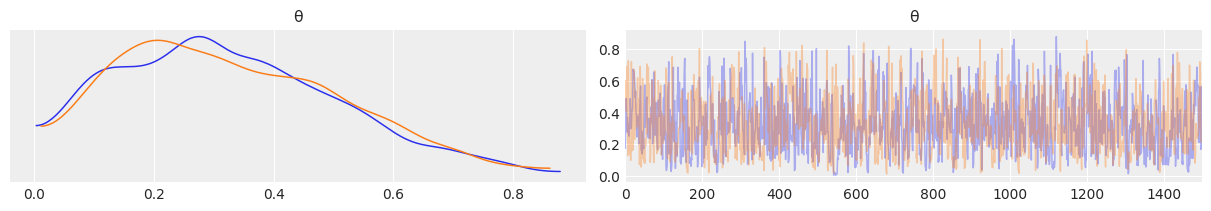

In [594]:
az.plot_trace(az.from_numpyro(mcmc), compact=False)
plt.show()

In [595]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         θ      0.33      0.18      0.31      0.05      0.61   1051.12      1.00

Number of divergences: 0


#### Posterior-based decisions

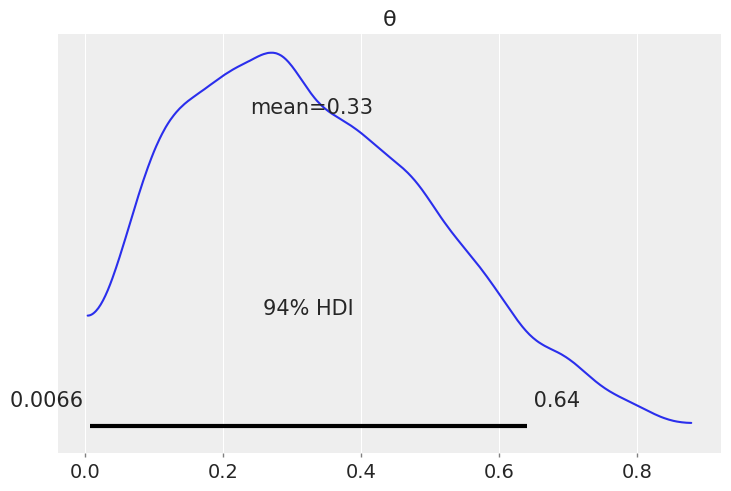

In [596]:
az.plot_posterior(az.from_numpyro(mcmc))
plt.show()

<AxesSubplot:title={'center':'θ'}>

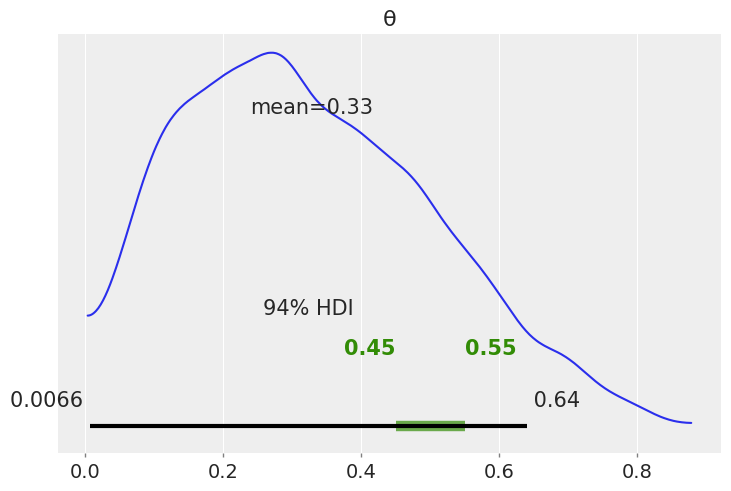

In [597]:
az.plot_posterior(az.from_numpyro(mcmc), rope=[0.45, .55])

<AxesSubplot:title={'center':'θ'}>

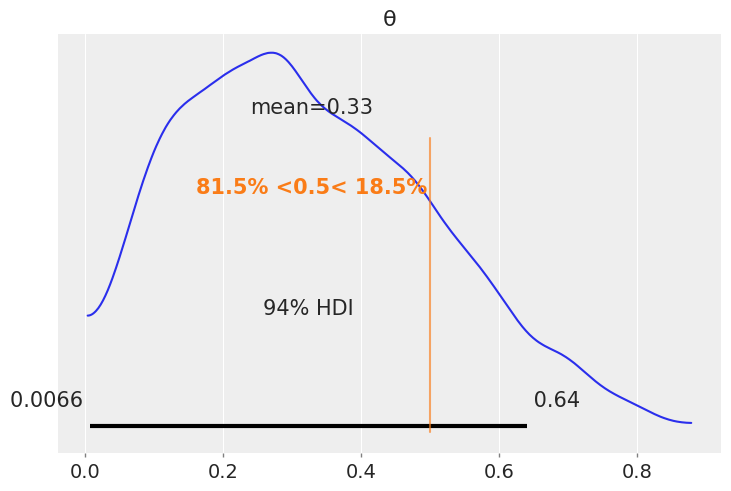

In [598]:
az.plot_posterior(az.from_numpyro(mcmc), ref_val=0.5)

In [599]:
mcmc.get_samples(group_by_chain=True)

{'θ': DeviceArray([[0.17285858, 0.32812756, 0.48738322, ..., 0.16604272,
               0.4787685 , 0.5638707 ],
              [0.57522225, 0.6004805 , 0.4808577 , ..., 0.22368269,
               0.21266927, 0.21266927]], dtype=float32)}

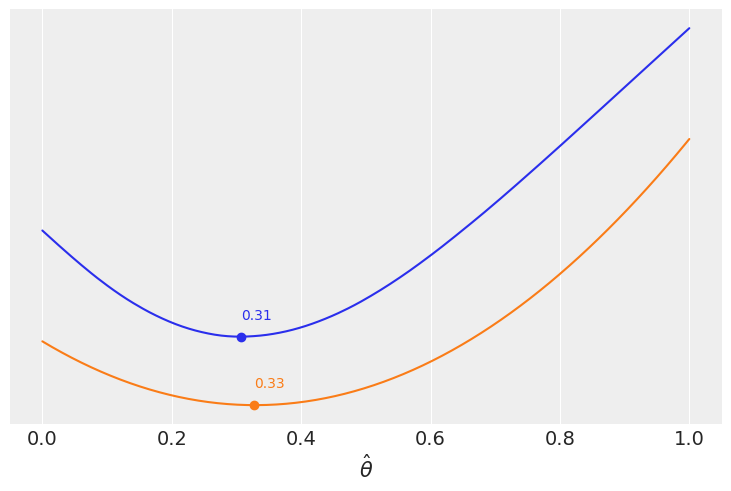

In [600]:
grid = jnp.linspace(start=0, stop=1, num=200)
θ_pos = mcmc.get_samples()["θ"]
lossf_a = [jnp.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [jnp.mean((i - θ_pos)**2) for i in grid]

for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = jnp.argmin(jnp.asarray(lossf))
    plt.plot(grid, lossf, c)
    plt.plot(grid[mini], lossf[mini], 'o', color=c)
    plt.annotate('{:.2f}'.format(grid[mini]),
                 (grid[mini], lossf[mini] + 0.03), color=c)
    plt.yticks([])
    plt.xlabel(r'$\hat \theta$')

In [601]:
jnp.mean(θ_pos), jnp.median(θ_pos)

(DeviceArray(0.32869053, dtype=float32),
 DeviceArray(0.30531082, dtype=float32))

Text(0.5, 0, '$\\hat \\theta$')

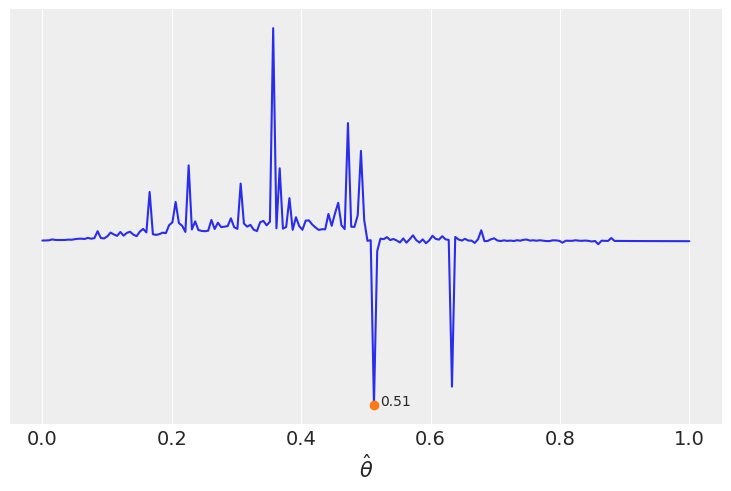

In [602]:
lossf = []
for i in grid:
    if i < 0.5:
        f = jnp.mean(jnp.pi * θ_pos / jnp.abs(i - θ_pos))
    else:
        f = jnp.mean(1 / (i - θ_pos))
    lossf.append(f)

mini = jnp.argmin(jnp.asarray(lossf))
plt.plot(grid, lossf)
plt.plot(grid[mini], lossf[mini], 'o')
plt.annotate('{:.2f}'.format(grid[mini]),
             (grid[mini] + 0.01, lossf[mini] + 0.1))
plt.yticks([])
plt.xlabel(r'$\hat \theta$')

## Gaussian inferences

In [603]:
data = pd.read_csv('../data/chemical_shifts.csv', header=None)
data.head()

,0
0,51.06
1,55.12
2,53.73
3,50.24
4,52.05


In [604]:
data = jnp.asarray(data)
data.shape

(48, 1)

([<matplotlib.axis.YTick at 0x158da8a90>], [Text(0, 0, '')])

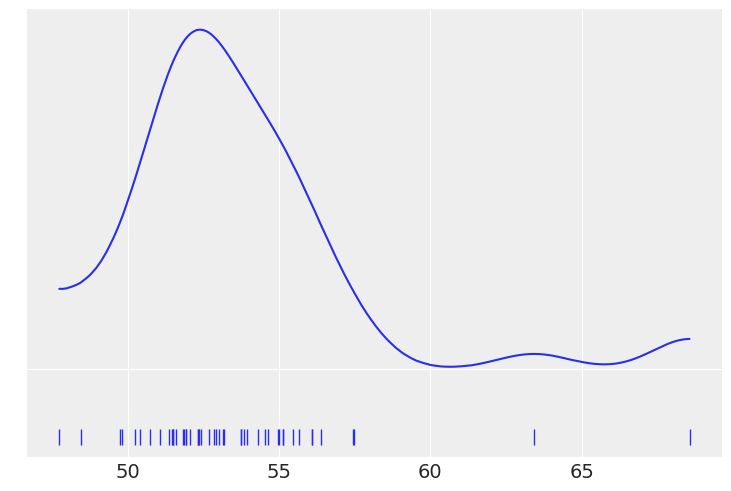

In [605]:
az.plot_kde(data, rug=True)
plt.yticks([0], alpha=0)

 <img src="./imgs/B11197_02_08.png" width="500">

In [690]:
def model(N=100, obs=None):
    μ = numpyro.sample('μ', dist.Uniform(low=40., high=70.))
    σ = numpyro.sample('σ', dist.HalfNormal(scale=10.))
    with numpyro.plate("N", N):
        numpyro.sample('y', dist.Normal(loc=μ, scale=σ), obs=obs)

    
kernel = NUTS(model)
mcmc2 = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=2)
mcmc2.run(random.PRNGKey(seed), obs=data)

sample: 100%|██████████████████████████| 1000/1000 [00:00<00:00, 5742.88it/s, 3 steps of size 6.60e-01. acc. prob=0.93]


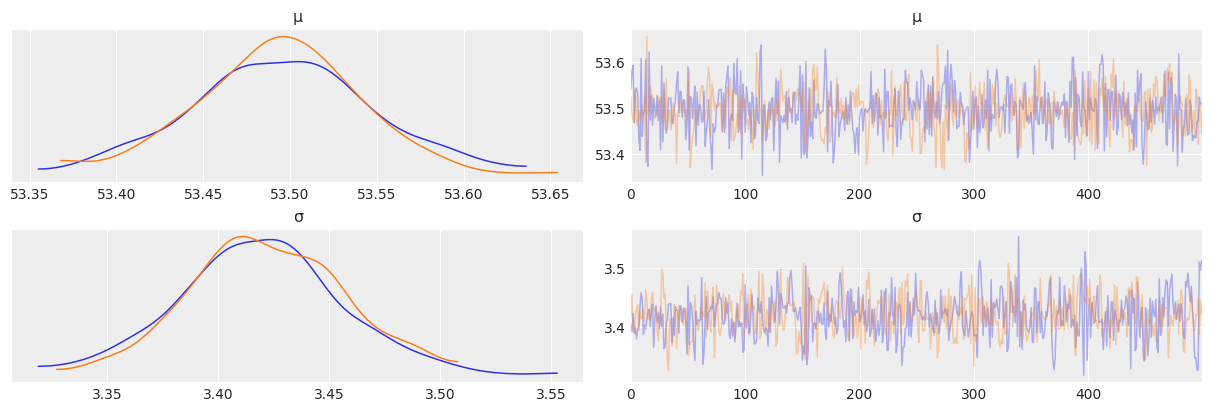

In [691]:
az.plot_trace(az.from_numpyro(mcmc2), compact=False)
plt.show()

array([<AxesSubplot:xlabel='μ', ylabel='σ'>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

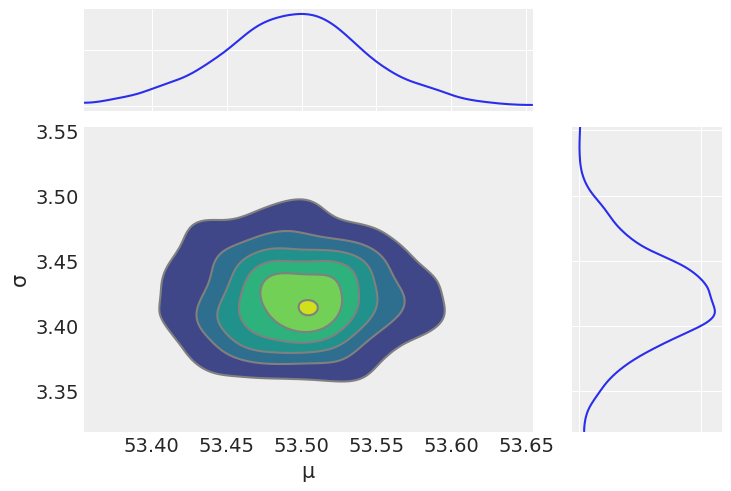

In [692]:
az.plot_joint(az.from_numpyro(mcmc2), var_names=['μ', 'σ'], kind='kde', fill_last=False)

In [693]:
mcmc2.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         μ     53.49      0.05     53.50     53.40     53.57    787.94      1.00
         σ      3.42      0.04      3.42      3.36      3.48    685.76      1.00

Number of divergences: 0


In [694]:
az.summary(mcmc2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,53.495,0.049,53.405,53.594,0.002,0.001,795.0,675.0,1.01
σ,3.420,0.035,3.356,3.491,0.001,0.001,693.0,579.0,1.00


---

In [695]:
prior = Predictive(mcmc2.sampler.model, num_samples=10)
prior_p = prior(random.PRNGKey(seed), obs=data)

In [721]:
pred = Predictive(model=mcmc2.sampler.model, posterior_samples=mcmc2.get_samples(), return_sites=['y'])
post_p = pred(random.PRNGKey(seed), N=100)

In [722]:
# post_p['y'] = post_p['y'].squeeze()
# post_p['y'] = jnp.expand_dims(post_p['y'], axis=1) --> Seems line not needed
post_p['y'].shape

(1000, 100)

In [723]:
post_p['y'] = post_p['y'][:50]

In [724]:
post_p['y'].shape

(50, 100)

In [725]:
jnp.sort(post_p['y'][0])

DeviceArray([44.29414 , 44.349854, 46.441837, 46.689426, 46.796425,
             47.03588 , 47.583427, 47.596024, 48.212406, 48.726635,
             48.813835, 48.84052 , 49.055523, 49.085613, 49.60701 ,
             49.714584, 49.80934 , 49.83368 , 49.943848, 50.031883,
             50.160152, 50.25194 , 50.320923, 50.334843, 50.518284,
             50.518463, 50.6463  , 50.69864 , 50.728085, 50.96986 ,
             51.064117, 51.330784, 51.572712, 51.629684, 51.821022,
             51.835228, 51.87946 , 51.93214 , 52.314796, 52.3805  ,
             52.59526 , 52.771126, 52.853275, 52.88644 , 53.019768,
             53.135284, 53.27581 , 53.30327 , 53.48876 , 53.51001 ,
             53.626865, 53.722065, 53.72291 , 53.811417, 53.82796 ,
             53.831795, 53.83189 , 53.83466 , 54.084534, 54.088604,
             54.338524, 54.603535, 54.712193, 54.74976 , 54.75797 ,
             54.77956 , 54.86422 , 54.87436 , 54.945034, 54.96186 ,
             55.11813 , 55.122982, 55.267242, 55

In [731]:
# samples = az.from_numpyro(mcmc2, prior=prior_p, posterior_predictive=post_p)
samples = az.from_numpyro(mcmc2, prior=prior_p, posterior_predictive=post_p) # Priop p seems not required.
# az.summary(samples)

In [732]:
samples.groups()

['posterior',
 'posterior_predictive',
 'log_likelihood',
 'sample_stats',
 'prior',
 'prior_predictive',
 'observed_data']

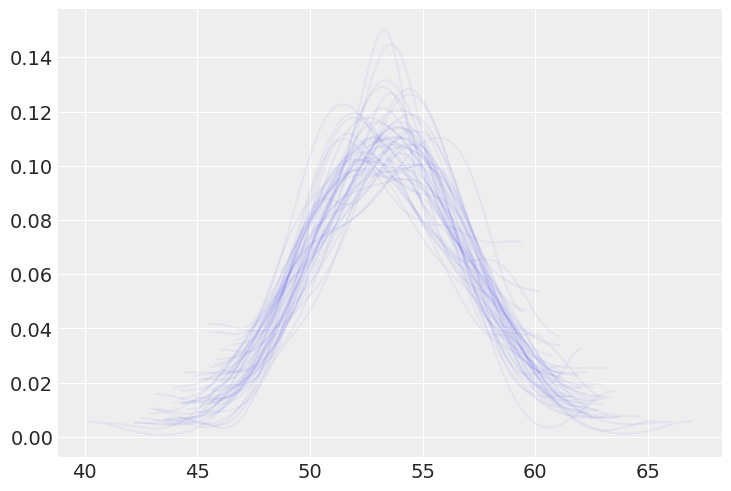

In [733]:
fig, ax = plt.subplots()
for i in post_p['y']:
    ax = az.plot_kde(i, ax=ax, plot_kwargs={'alpha': 0.05})

(40.0, 70.0)

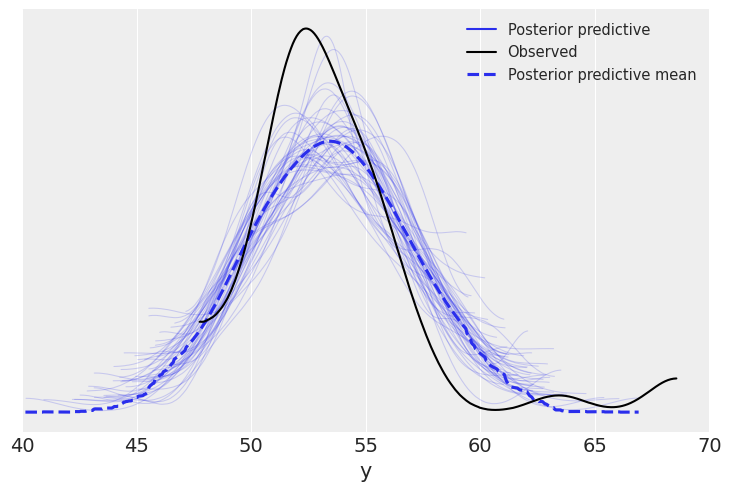

In [734]:
az.plot_ppc(samples, mean=True, observed=True)
plt.xlim(40, 70)

---

### Robust inferences

(-5.0, 5.0)

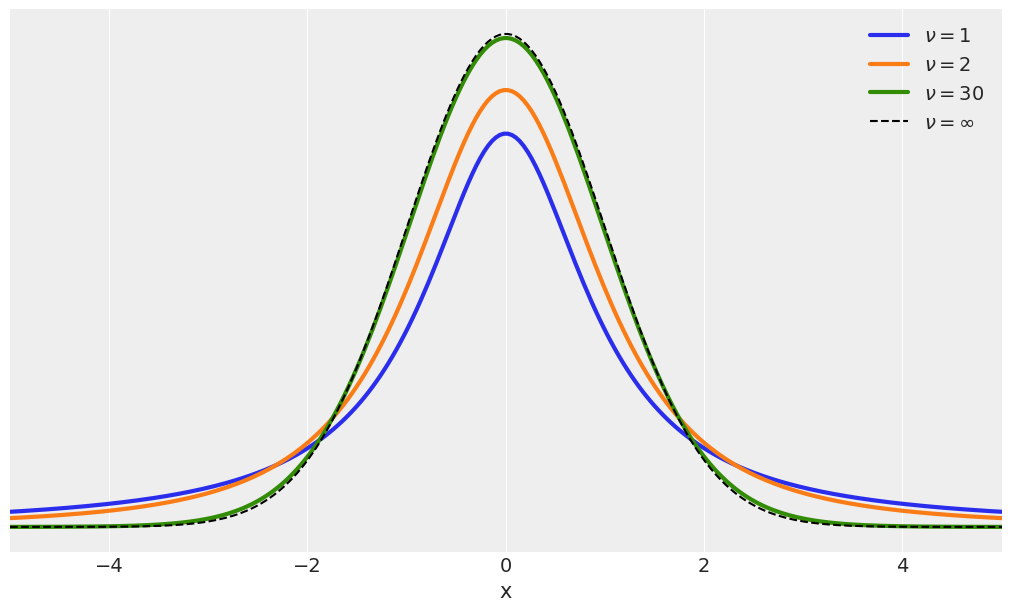

In [738]:
plt.figure(figsize=(10, 6))
x_values = jnp.linspace(start=-10, stop=10, num=500)
for df in [1, 2, 30]:
    distri = dist.StudentT(df)
    x_pdf = jnp.exp(distri.log_prob(x_values))
    plt.plot(x_values, x_pdf, label=fr'$\nu = {df}$', lw=3)

x_pdf = jnp.exp(dist.Normal().log_prob(x_values))
plt.plot(x_values, x_pdf, 'k--', label=r'$\nu = \infty$')
plt.xlabel('x')
plt.yticks([])
plt.legend()
plt.xlim(-5, 5)

 <img src="./imgs/B11197_02_13.png" width="500">

In [747]:
def model(N=100, obs=None):
    μ = numpyro.sample('μ', dist.Uniform(low=40., high=75.))
    σ = numpyro.sample('σ', dist.HalfNormal(scale=10.))
    ν = numpyro.sample('ν', dist.Exponential(rate=1/30))
    
    with numpyro.plate("N", N):
        numpyro.sample('y', dist.StudentT(ν, loc=μ, scale=σ), obs=obs)

    
kernel = NUTS(model)
mcmc3 = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=2)
mcmc3.run(random.PRNGKey(seed), obs=data)

sample: 100%|██████████████████████████| 1000/1000 [00:00<00:00, 4900.25it/s, 3 steps of size 6.52e-01. acc. prob=0.90]


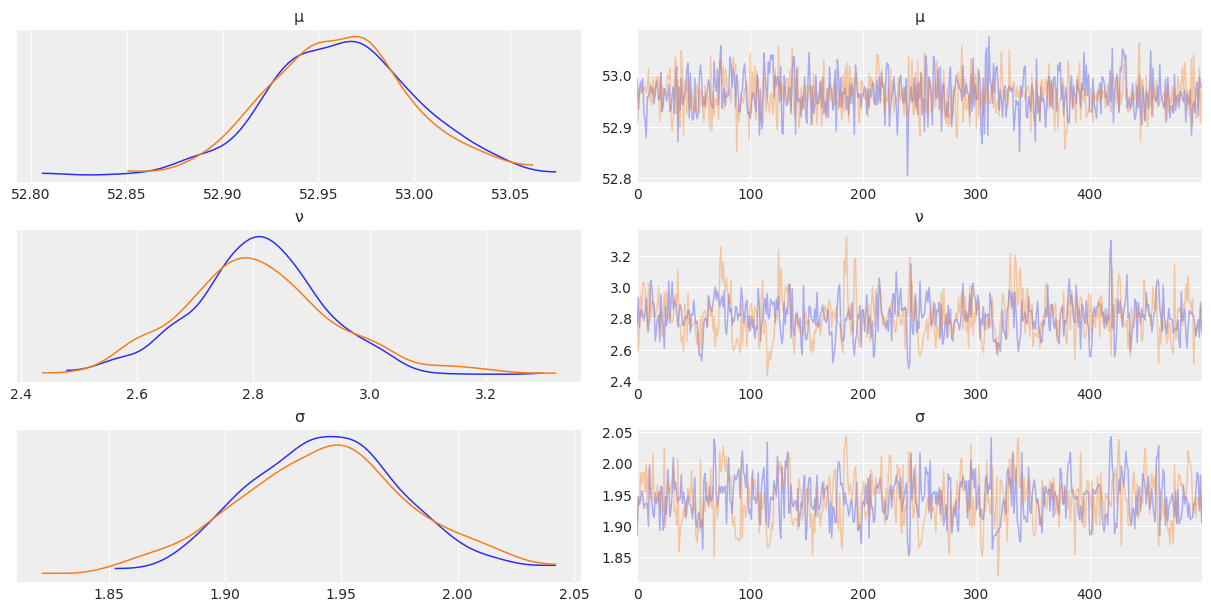

In [748]:
az.plot_trace(az.from_numpyro(mcmc3), compact=False)
plt.show()

In [749]:
az.summary(mcmc3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,52.962,0.037,52.897,53.039,0.001,0.001,1085.0,748.0,1.00
ν,2.809,0.125,2.577,3.037,0.006,0.005,380.0,429.0,1.00
σ,1.944,0.036,1.880,2.017,0.002,0.001,421.0,444.0,1.01


In [756]:
prior = Predictive(mcmc3.sampler.model, num_samples=10)
prior_p = prior(random.PRNGKey(seed), obs=data)

pred = Predictive(model=mcmc3.sampler.model, posterior_samples=mcmc3.get_samples(), return_sites=['y'])
post_p = pred(random.PRNGKey(seed), N=100)

In [757]:
post_p['y'] = post_p['y'][:100]

In [758]:
samples = az.from_numpyro(mcmc2, prior=prior_p, posterior_predictive=post_p)

(40.0, 70.0)

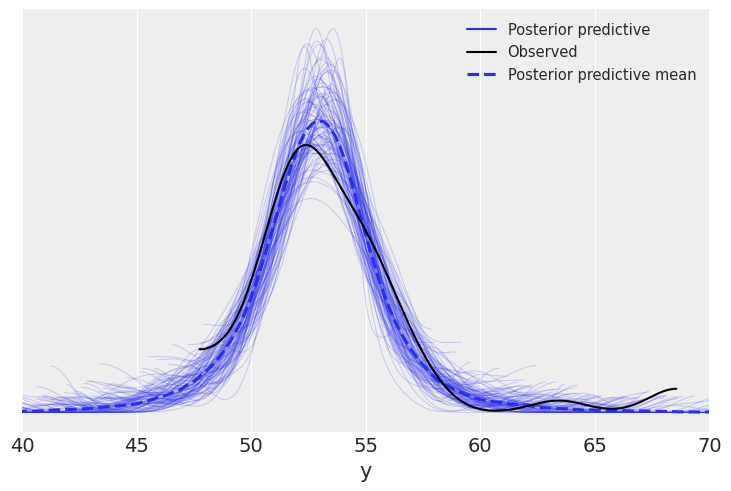

In [764]:
az.plot_ppc(samples, mean=True, observed=True, color='C0')
plt.xlim(40, 70)

# Tips example

In [765]:
tips = pd.read_csv('../data/tips.csv')
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


In [783]:
x = az.dict_to_dataset(tips.to_dict())

In [789]:
type(x.data_vars)

xarray.core.dataset.DataVariables

AttributeError: 'dict' object has no attribute 'dtype'

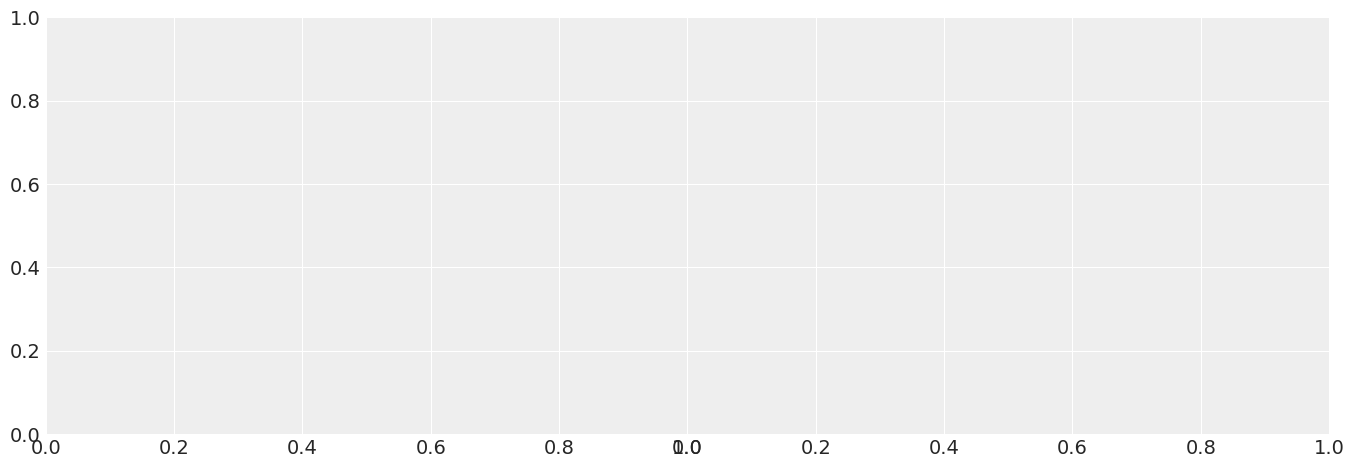

In [790]:
az.plot_violin(x, var_names=['day', 'tip'])

In [ ]:
tip = tips['tip'].values
idx = pd.Categorical(tips['day'],
                     categories=['Thur', 'Fri', 'Sat', 'Sun']).codes
groups = len(np.unique(idx))

In [ ]:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=tip)

    trace_cg = pm.sample(5000)
az.plot_trace(trace_cg)
plt.savefig('B11197_02_17.png', dpi=300)

In [ ]:
dist = stats.norm()

_, ax = plt.subplots(3, 2, figsize=(14, 8), constrained_layout=True)

comparisons = [(i, j) for i in range(4) for j in range(i+1, 4)]
pos = [(k, l) for k in range(3) for l in (0, 1)]

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = trace_cg['μ'][:, i] - trace_cg['μ'][:, j]
    d_cohen = (means_diff / np.sqrt((trace_cg['σ'][:, i]**2 + trace_cg['σ'][:, j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l])
    ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
    ax[k, l].plot(
        0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax[k, l].legend()
plt.savefig('B11197_02_18.png', dpi=300)

# Hierarchical Models

 <img src="./imgs/B11197_02_19.png" width="500">

In [ ]:
N_samples = [30, 30, 30]
G_samples = [18, 18, 18]  # [3, 3, 3]  [18, 3, 3]

group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))

In [ ]:
with pm.Model() as model_h:
    μ = pm.Beta('μ', 1., 1.)
    κ = pm.HalfNormal('κ', 10)

    θ = pm.Beta('θ', alpha=μ*κ, beta=(1.0-μ)*κ, shape=len(N_samples))
    y = pm.Bernoulli('y', p=θ[group_idx], observed=data)

    trace_h = pm.sample(2000)

In [ ]:
az.plot_trace(trace_h)
plt.savefig('B11197_02_20.png', dpi=300)

In [ ]:
az.summary(trace_h)

In [ ]:
x = np.linspace(0, 1, 100)
for i in np.random.randint(0, len(trace_h), size=100):
    u = trace_h['μ'][i]
    k = trace_h['κ'][i]
    pdf = stats.beta(u*k, (1.0-u)*k).pdf(x)
    plt.plot(x, pdf,  'C1', alpha=0.2)

u_mean = trace_h['μ'].mean()
k_mean = trace_h['κ'].mean()
dist = stats.beta(u_mean*k_mean, (1.0-u_mean)*k_mean)
pdf = dist.pdf(x)
mode = x[np.argmax(pdf)]
mean = dist.moment(1)
plt.plot(x, pdf, lw=3, label=f'mode = {mode:.2f}\nmean = {mean:.2f}')
plt.yticks([])

plt.legend()
plt.xlabel('$θ_{prior}$')
plt.tight_layout()
plt.savefig('B11197_02_21.png', dpi=300)

In [ ]:
cs_data = pd.read_csv('../data/chemical_shifts_theo_exp.csv')
diff = cs_data.theo.values - cs_data.exp.values
idx = pd.Categorical(cs_data['aa']).codes
groups = len(np.unique(idx))

In [ ]:
with pm.Model() as cs_nh:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff)

    trace_cs_nh = pm.sample(1000)

In [ ]:
with pm.Model() as cs_h:
    # hyper_priors
    μ_μ = pm.Normal('μ_μ', mu=0, sd=10)
    σ_μ = pm.HalfNormal('σ_μ', 10)

    # priors
    μ = pm.Normal('μ', mu=μ_μ, sd=σ_μ, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff)

    trace_cs_h = pm.sample(1000)

In [ ]:
_, axes = az.plot_forest([trace_cs_nh, trace_cs_h],
                         model_names=['n_h', 'h'],
                         var_names='μ', combined=False, colors='cycle')
y_lims = axes[0].get_ylim()
axes[0].vlines(trace_cs_h['μ_μ'].mean(), *y_lims)
plt.savefig('B11197_02_22.png', dpi=300)